In [76]:
import glob
import os
import random
import re
import string

import contractions
import emoji
import matplotlib.pyplot as plt 
import nltk
import numpy as np
import pandas as pd
import seaborn as sns 
import spacy
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    TfidfTransformer,
)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from wordcloud import WordCloud

In [2]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "data/*.csv"))
dfs = []
for file_ in csv_files:
    dfs.append(df:=pd.read_csv(file_))
    display(df.shape)

display(len(dfs))

(5000, 8)

(2447, 8)

(1764, 8)

(5000, 8)

(1753, 8)

(2672, 8)

(797, 8)

(749, 8)

(4253, 8)

(3215, 8)

(3311, 8)

(3658, 8)

(1921, 8)

(2159, 8)

(1481, 8)

(5000, 8)

(4711, 8)

(1301, 8)

(1195, 8)

(2617, 8)

(1658, 8)

21

In [3]:
df = pd.concat(dfs, ignore_index=True, sort=False)

display(df.shape, df.sample(5))

(56662, 8)

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
6498,"EMEET 1080P Webcam with Microphone, C960 Web C...",2.0,Washed out video - so disappointed,Reviewed in the United States 🇺🇸 on February 2...,Color: Black,True,Very disappointed in the video quality. Looked...,NaN
13574,Nintendo USB Switch Pro Controller,5.0,Works great!,"Reviewed in the United States 🇺🇸 on January 2,...",Color: Black | Edition: Single,True,Works great!,NaN
31843,Kindle Oasis – With 7” display and page turn b...,4.0,Sensitive,Reviewed in the United States 🇺🇸 on September ...,Digital Storage Capacity: 8 GB | Offer Type: L...,True,"Wish this would display text horizontally, ove...",NaN
7241,"EMEET 1080P Webcam with Microphone, C960 Web C...",5.0,Great product for a great price!,"Reviewed in the United States on April 13, 2021",Color: Black,True,Wasn't expecting something this nice! Would hi...,NaN
23498,Apple Pencil (2nd Generation),1.0,Pencil received broken,"Reviewed in the United States on April 30, 2022",NaN,True,Pencil was received with missing parts and doe...,NaN


### Data prep

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56662 entries, 0 to 56661
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_name       56662 non-null  object 
 1   rating             56662 non-null  float64
 2   title              56643 non-null  object 
 3   location_and_date  56662 non-null  object 
 4   options            42473 non-null  object 
 5   verified_purchase  56662 non-null  bool   
 6   text               56507 non-null  object 
 7   helpful_count      13455 non-null  object 
dtypes: bool(1), float64(1), object(6)
memory usage: 3.1+ MB


**Drop duplicated rows**

In [5]:
subset = ['product_name', 'rating', 'title', 'text', 'helpful_count']
df[df.duplicated(subset)]

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
106,Seagate Portable 2TB External Hard Drive HDD —...,5.0,👍,"Reviewed in the United States on March 17, 2023",NaN,True,👍,NaN
1286,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Good,"Reviewed in the United States 🇺🇸 on June 4, 2022",NaN,True,Good,NaN
1408,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Perfect,"Reviewed in the United States on May 19, 2022",NaN,True,Perfect,NaN
2925,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Excelente,"Reviewed in the United States on November 21, ...",NaN,True,Excelente,NaN
3360,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Good,Reviewed in the United States 🇺🇸 on September ...,NaN,True,Good,NaN
...,...,...,...,...,...,...,...,...
54987,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Great,Reviewed in the United States 🇺🇸 on November 1...,Style: WiFi | Size: 64GB | Color: Space Gray,True,Wow can u say fast shipping and great apple pr...,NaN
56484,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Works great!,"Reviewed in the United States on December 26, ...",Color: Dark Gray | Size: 64GB,True,I like how fast it is.,NaN
56504,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Ok,"Reviewed in the United States on August 18, 2022",Color: Dark Gray | Size: 32GB,True,Ok,NaN
56596,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Excellent,"Reviewed in the United States on September 29,...",Color: Silver | Size: 64GB,True,Excellent,NaN


In [6]:
df = df.drop_duplicates(subset)

df[df.duplicated(subset)]

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count


**Check missing values:**

In [7]:
df.isnull().sum()

product_name             0
rating                   0
title                   17
location_and_date        0
options              14054
verified_purchase        0
text                   153
helpful_count        42859
dtype: int64

There are some missing values of `text` column which are should be dropped. Empty `options` values can be ignored as its not a part of sentiment analysis. For further analysis missing values of `helpful_count` should be replaced with zeros.

In [8]:
df = df.dropna(subset=['text'])

df.isnull().sum()

product_name             0
rating                   0
title                   11
location_and_date        0
options              14016
verified_purchase        0
text                     0
helpful_count        42764
dtype: int64

**Process `helpful_count` column**

1. Extract numeric values.
2. Replace NaN values with 0.
3. Cast into integer.

In [9]:
df['helpful_count'] = df['helpful_count'].str.replace(' people found this helpful', '', regex=False)
df['helpful_count'] = df['helpful_count'].str.replace(',', '', regex=False)
df['helpful_count'] = df['helpful_count'].str.replace('One person found this helpful', '1', regex=False)
df['helpful_count'] = df['helpful_count'].fillna(value=0)
df['helpful_count'] = df['helpful_count'].astype('int')

df.sample(5)

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
52810,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Worth the upgrade!!,"Reviewed in the United States on November 28, ...",Style: WiFi | Size: 64GB | Color: Space Gray,True,Received my iPad package neatly and new! Best...,1
5040,"EMEET 1080P Webcam with Microphone, C960 Web C...",5.0,Does what it should for the price,"Reviewed in the United States on April 3, 2023",Color: Black,True,"Nothing fancy, just a working camera that you ...",0
2318,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Fast Reliable hard drive !!,"Reviewed in the United States 🇺🇸 on March 13, ...",NaN,True,All good things regarding this ..fast transfer...,0
10591,Nintendo USB Switch Pro Controller,5.0,Great controller,"Reviewed in the United States on March 31, 2021",Color: Black | Edition: Single,True,This is such a huge improvement over the stock...,0
38260,Nintendo Switch Lite - Turquoise,2.0,Came with a dead charger,"Reviewed in the United States 🇺🇸 on March 3, 2020",Color: Turquoise | Style: Lite Console,True,Unfortunately my product came with a dead char...,0


**Handle `location_and_date` column**

1. Split it into `location` and `date` columns (hold location if it has various values).
2. Convert `date` into datetime format.
3. Drop `location_and_date` column.

In [10]:
location_and_date = df['location_and_date'].str.extract(r'Reviewed in ([\w\s]+).+on\s(\w+\s\d{1,2},\s\d{4})')
location = location_and_date[0].str.strip()
location.unique()

array(['the United States'], dtype=object)

As all the reviews are from the US, `location` column can be ommitted.

In [11]:
df['date'] = pd.to_datetime(location_and_date[1], format='%B %d, %Y')

**Drop unneeded columns**

In [12]:
df.drop(['location_and_date', 'options'], axis=1, inplace=True)

In [13]:
df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date
54119,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Bought for my grandson,True,My grandson loves this iPad!,0,2022-01-07
17069,HP 24mh FHD Monitor - Computer Monitor with 23...,5.0,Super Good for 110 $,True,It hits 75Hz refresh no problem. Excellent mon...,0,2021-06-01
15153,Nintendo Switch – OLED Model w/ Neon Red & Neo...,5.0,100% Satisfied,True,I received my order yesterday and I'm 100% sat...,2,2021-10-22
5339,"EMEET 1080P Webcam with Microphone, C960 Web C...",3.0,Not very good,True,"The image quality isn't very good, I appear li...",0,2022-10-28
24999,"Kindle Paperwhite (8 GB) – Now with a 6.8"" dis...",5.0,Love It!!,True,My husband bought me this for Christmas to rep...,0,2023-01-15


**Convert rating from numbers to categories**

In [14]:
df['positivity'] = np.where(df['rating'] > 3, 1, 0)

df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date,positivity
7190,"EMEET 1080P Webcam with Microphone, C960 Web C...",5.0,Good product for the money.,True,Good product for the money.,0,2023-02-14,1
14439,Nintendo Switch – OLED Model w/ Neon Red & Neo...,5.0,Christmas Present,True,My Daughter loves it!,0,2023-01-16,1
32623,Kindle Oasis – With 7” display and page turn b...,5.0,Best Kindle that I have owned,True,I have owned (2) Paperwhites prior and was mos...,0,2019-12-24,1
24616,"Kindle Paperwhite (8 GB) – Now with a 6.8"" dis...",4.0,"Kindle is great Kindle ""unlimited"" is not",True,"If you don't have KU (Kindle ""unlimited"") then...",0,2023-03-19,1
29036,"Sceptre 24"" Professional Thin 75Hz 1080p LED M...",5.0,Perfectly priced,True,What a fantastic monitor for the price. Bought...,0,2020-07-06,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56137 entries, 0 to 56661
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_name       56137 non-null  object        
 1   rating             56137 non-null  float64       
 2   title              56126 non-null  object        
 3   verified_purchase  56137 non-null  bool          
 4   text               56137 non-null  object        
 5   helpful_count      56137 non-null  int64         
 6   date               56137 non-null  datetime64[ns]
 7   positivity         56137 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 3.5+ MB


In [16]:
df.describe()

,rating,helpful_count,date,positivity
count,56137.000000,56137.000000,56137,56137.000000
mean,4.153856,3.077810,2021-06-14 14:17:37.997399296,0.769207
min,1.000000,0.000000,2017-03-04 00:00:00,0.000000
25%,4.000000,0.000000,2020-07-13 00:00:00,1.000000
50%,5.000000,0.000000,2021-08-15 00:00:00,1.000000
75%,5.000000,0.000000,2022-08-20 00:00:00,1.000000
max,5.000000,7976.000000,2023-04-18 00:00:00,1.000000
std,1.390729,63.364648,NaN,0.421344


In [17]:
df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date,positivity
55395,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,3.0,It's just OK. What do you expect for $200?,True,"Entry level and laggy, with not a lot of space...",1,2022-05-11,0
53221,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Great device,True,"Great, and in keeping with the Apple iPad trad...",0,2022-10-02,1
41550,Logitech MK270 Wireless Keyboard And Mouse Com...,5.0,good product,True,good product,0,2022-06-03,1
24871,"Kindle Paperwhite (8 GB) – Now with a 6.8"" dis...",5.0,Life Saver! Never Gonna Give It Up!,True,The Kindle Paperwhite 11th generation is perfe...,14,2022-08-22,1
37308,Nintendo Switch Lite - Turquoise,5.0,Love it,True,"So much fun, and my daughter loves it. Great p...",0,2021-01-18,1


### Data exploration

In [18]:
sns.set_theme(style='whitegrid')

**Review length distribution**

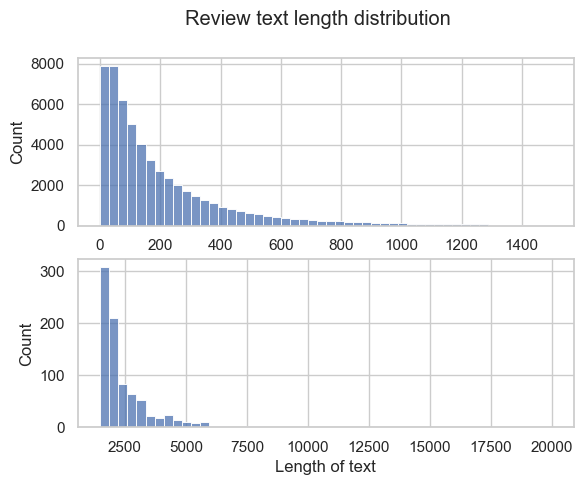

In [19]:
pl_df = pd.DataFrame()
pl_df['text_length'] = df['text'].apply(len)

fig, axs = plt.subplots(nrows=2)
sns.histplot(data=pl_df[pl_df.text_length < 1500],
             x='text_length', bins=50, ax=axs[0])
sns.histplot(data=pl_df[pl_df.text_length >= 1500],
             x='text_length', bins=50, ax=axs[1])
axs[1].set_xlabel('Length of text')
fig.suptitle('Review text length distribution')
plt.show()

**Frequency distribution of n-grams**

In [20]:
def preprocess_review_text(text):
    text = str(text).lower()
    # Expand contractions
    text = contractions.fix(text)
    # Replace emojis with its aliases
    text = emoji.demojize(text)
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove tags
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # Remove stop words
    text = ' '.join((
        word for word in text.split() if word not in stopwords.words('english')))    
    return text

In [21]:
kwargs = {
    'preprocessor': preprocess_review_text,
    'ngram_range': (1, 1),
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',  # Split text into word tokens.
}
vectorizer = CountVectorizer(**kwargs)
vectorized_texts = vectorizer.fit_transform(df['text'])
all_ngrams = list(vectorizer.get_feature_names_out())
num_ngrams = min(50, len(all_ngrams))
all_counts = vectorized_texts.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(all_counts, all_ngrams), reverse=True)])
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]

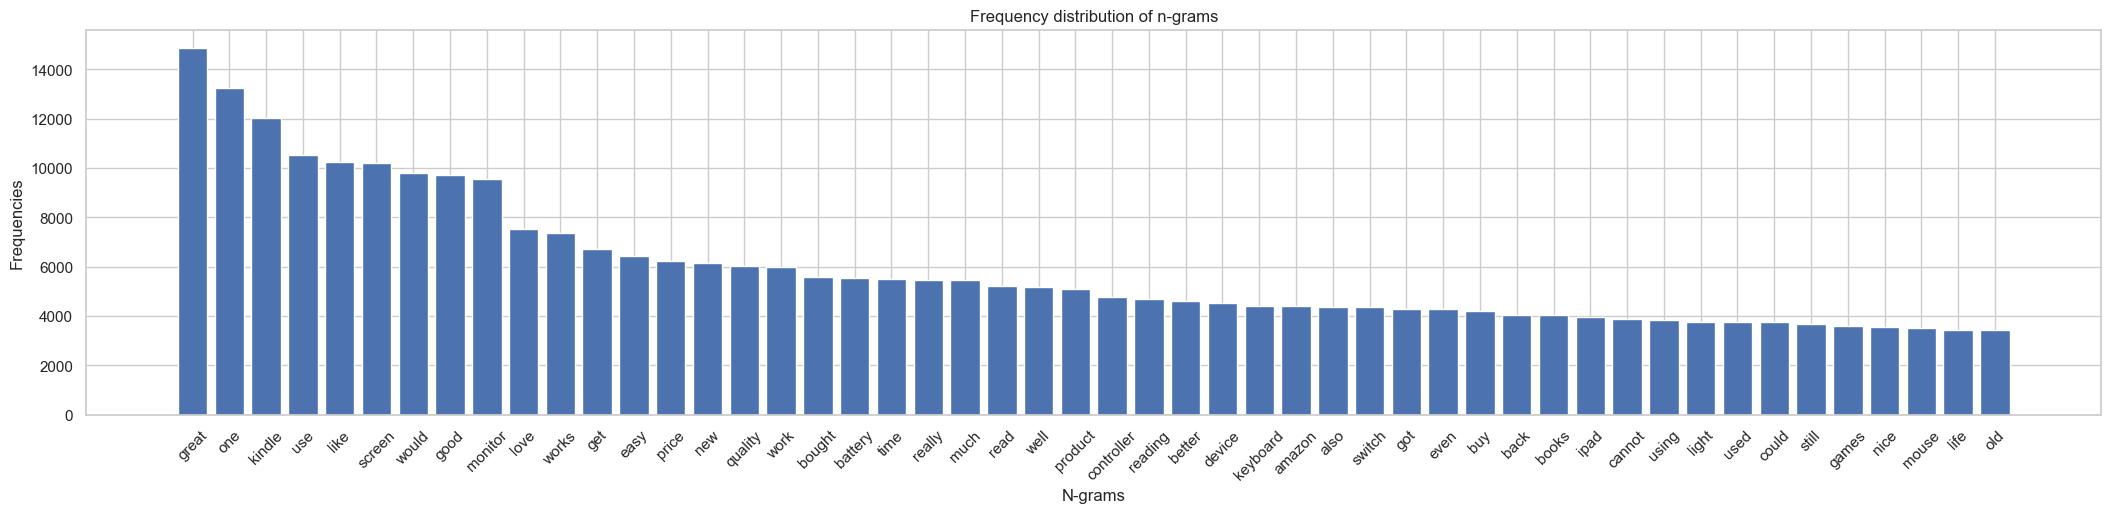

In [22]:
fig, ax = plt.subplots(figsize=(26, 5))
idx = np.arange(num_ngrams)
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of n-grams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

**Rating distribution**

ValueError: Could not interpret value `rating` for parameter `x`

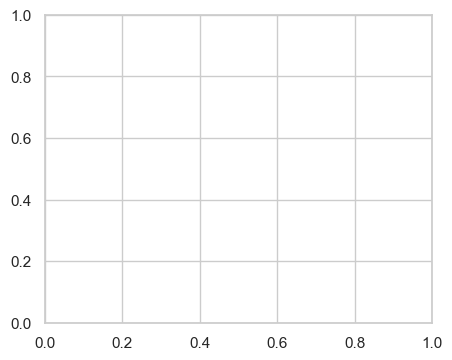

In [85]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=df, x='rating', color='b', alpha=1,
             stat='percent', shrink=.8, discrete=True)
fig.suptitle('Review rating')
plt.ylim(0, 70)
plt.show()

**Visualization of most frequent words with Word Cloud**

In [24]:
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def visualize(positivity):
    plt.figure(figsize=(9, 6), facecolor='None')
    vectorizer = TfidfVectorizer(preprocessor=preprocess_review_text, min_df=250)
    X = vectorizer.fit_transform(df[df['positivity'] == positivity]['text'])
    f_df = pd.DataFrame(X.todense().tolist(), columns=vectorizer.get_feature_names_out())
    wordcloud = WordCloud(
        width=900, height=600, max_words=300,
        background_color='white', color_func=black_color_func,
    ).generate_from_frequencies(f_df.T.sum(axis=1))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(
        "Most frequent words in "
        f"{'posititve' if positivity else 'negative and neutral'}"
        " reviews",
        fontsize=14
    )
    plt.show()

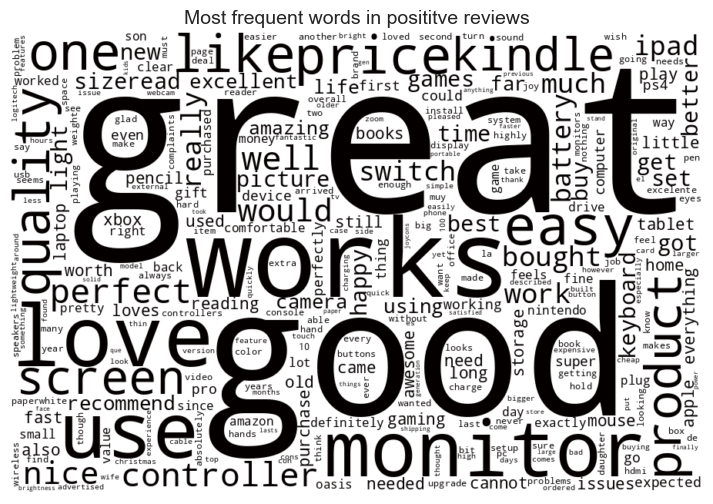

In [25]:
visualize(1)

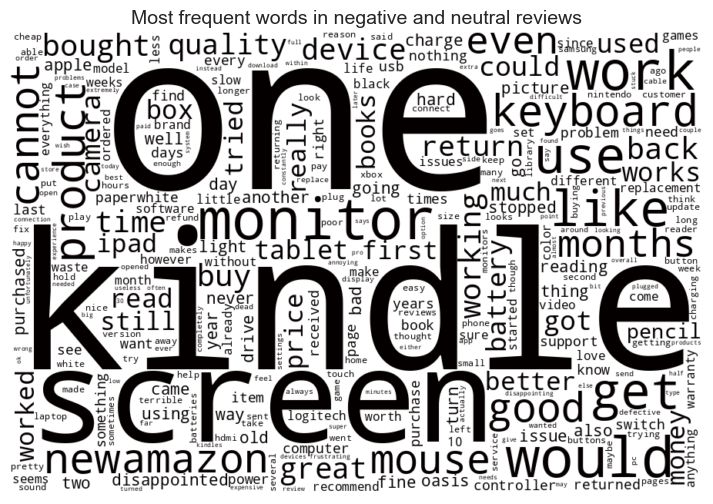

In [26]:
visualize(0)

In [27]:
df = df[['text', 'positivity']]
df.shape

(56137, 2)

### Logistic Regression

**Split data**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['positivity'], random_state=0)

display(X_train.shape, X_test.shape)

(42102,)

(14035,)

In [29]:
roc_auc_data = {}

**Prepare custom preprocessor**

In [30]:
def preprocess_review_text(text):
    text = str(text).lower()
    # Expand contractions
    text = contractions.fix(text)
    # Replace emojis with its aliases
    text = emoji.demojize(text)
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove tags
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return text

**1. CountVectorizer**

In [31]:
vectorizer = CountVectorizer(preprocessor=preprocess_review_text).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)

len(vectorizer.get_feature_names_out())

25242

In [32]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['CountVectorizer'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.833


**2. TfidfVectorizer**

In [33]:
NGRAM_RANGE = (1, 2)
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
    'preprocessor': preprocess_review_text,
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
}

vectorizer = TfidfVectorizer(**kwargs)

In [34]:
X_train_vectorized = vectorizer.fit_transform(X_train)

len(vectorizer.get_feature_names_out())

7746

In [35]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.839


**3. TfidfVectorizer with n-grams**

In [36]:
NGRAM_RANGE = (1, 2)
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
    'preprocessor': preprocess_review_text,
    'ngram_range': NGRAM_RANGE,
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
}

vectorizer = TfidfVectorizer(**kwargs)

In [37]:
X_train_vectorized = vectorizer.fit_transform(X_train)

len(vectorizer.get_feature_names_out())

52242

In [38]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer with n-grams'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.840


**4. TfidfVectorizer with n-grams and top K features**

In [39]:
X_test_vectorized = vectorizer.transform(X_test)

In [40]:
X_train_vectorized.shape, X_test_vectorized.shape

((42102, 52242), (14035, 52242))

In [41]:
TOP_K = 20000

selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vectorized.shape[1]))
selector.fit(X_train_vectorized, y_train.array)
X_train_vectorized = selector.transform(X_train_vectorized).astype('float32')
X_test_vectorized = selector.transform(X_test_vectorized).astype('float32')

In [42]:
X_train_vectorized.shape, X_test_vectorized.shape

((42102, 20000), (14035, 20000))

In [43]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer with n-grams and top K features'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.836


**Result**

In [44]:
for key, val in roc_auc_data.items():
    print('%.3f -- %s' % (val, key))

0.833 -- CountVectorizer
0.839 -- TfidfVectorizer
0.840 -- TfidfVectorizer with n-grams
0.836 -- TfidfVectorizer with n-grams and top K features


### ML with Keras and Tensorflow

In [45]:
df = df[['text', 'positivity']]
df.shape

(56137, 2)

In [46]:
N_TRAIN = int(0.6 * len(df))
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [47]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

In [48]:
train, valid, test = np.split(df.sample(frac=1), [N_TRAIN, int(0.8 * len(df))])

In [49]:
def df_to_dataset(dataframe, shuffle=True):
    df = dataframe.copy()
    labels = df.pop('positivity')
    df = df['text']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [50]:
def train_model(model, train_data, valid_data):
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

    history = model.fit(
        train_data,
        epochs=10,
        callbacks=callbacks,
        validation_data=valid_data,
        verbose=2,
        batch_size=BATCH_SIZE)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
          acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    return history

In [51]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [52]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [53]:
hub_layer(list(train_data)[0][0])

2023-04-19 19:05:09.876291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [33682]
	 [[{{node Placeholder/_0}}]]
2023-04-19 19:05:09.876592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [33682]
	 [[{{node Placeholder/_0}}]]
2023-04-19 19:05:09.995017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 7.8589630e-01,  1.0730329e-01,  8.1667662e-02, ...,
        -7.1452129e-01,  2.0365550e-01,  4.3987846e-01],
       [ 3.9026803e-01, -8.8726357e-03, -7.5363942e-06, ...,
        -1.4682378e-01, -1.1520084e-01,  1.3772185e-01],
       [ 4.2778242e-01, -9.9940844e-02, -1.2997353e-01, ...,
         2.3416400e-01,  5.5966634e-02,  2.6859513e-01],
       ...,
       [ 5.5221164e-01,  1.6443290e-01,  7.6624215e-02, ...,
        -3.6570925e-01,  1.2661417e-01,  2.3253818e-01],
       [ 1.0565558e-01, -2.2350514e-01,  9.3545213e-02, ...,
         1.9914009e-02,  4.7299480e-01, -3.4813978e-02],
       [ 3.2400650e-01,  2.4177030e-01,  3.1004950e-01, ...,
        -2.5896850e-01, -2.2390980e-02,  1.7457269e-01]], dtype=float32)>

**Basic model**

In [54]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='binary_crossentropy',
              metrics=['acc'])

history = train_model(model, train_data, valid_data)

Epoch 1/10


2023-04-19 19:05:10.432084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-04-19 19:05:10.628529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,50]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-19 19:05:10.628589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must 

66/66 - 49s - loss: 0.5215 - acc: 0.7776 - val_loss: 0.3777 - val_acc: 0.8423 - 49s/epoch - 736ms/step
Epoch 2/10
66/66 - 48s - loss: 0.2901 - acc: 0.8804 - val_loss: 0.2855 - val_acc: 0.8799 - 48s/epoch - 725ms/step
Epoch 3/10
66/66 - 49s - loss: 0.2092 - acc: 0.9173 - val_loss: 0.2710 - val_acc: 0.8901 - 49s/epoch - 737ms/step
Epoch 4/10
66/66 - 48s - loss: 0.1654 - acc: 0.9368 - val_loss: 0.2811 - val_acc: 0.8888 - 48s/epoch - 731ms/step
Epoch 5/10
66/66 - 48s - loss: 0.1345 - acc: 0.9521 - val_loss: 0.3047 - val_acc: 0.8855 - 48s/epoch - 734ms/step
Validation accuracy: 0.8854547142982483, loss: 0.3046990931034088


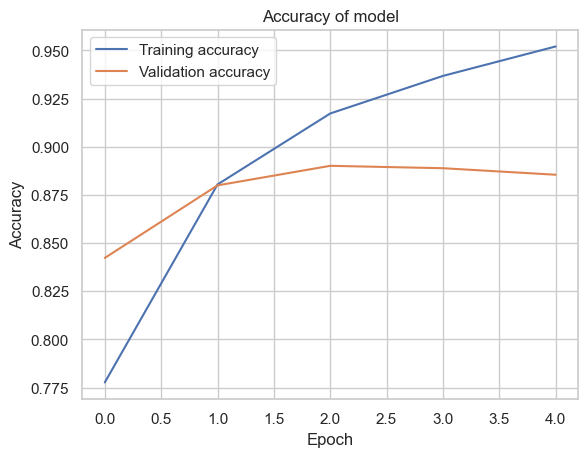

In [55]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

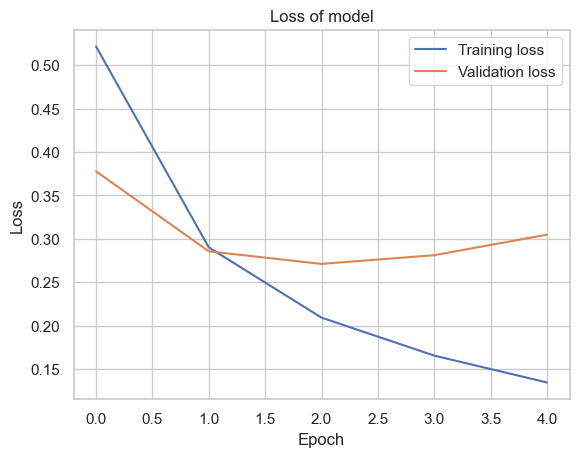

In [56]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
results = model.evaluate(test_data, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

2023-04-19 19:09:12.533114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11228]
	 [[{{node Placeholder/_0}}]]
2023-04-19 19:09:12.533368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11228]
	 [[{{node Placeholder/_0}}]]


22/22 - 2s - loss: 0.2988 - acc: 0.8883 - 2s/epoch - 113ms/step
loss: 0.299
acc: 0.888


**Model with dropout**

In [58]:
dropout_model = tf.keras.Sequential([
    hub_layer,
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                      loss='binary_crossentropy',
                      metrics=['acc'])

history = train_model(dropout_model, train_data, valid_data)

Epoch 1/10


2023-04-19 19:09:15.045437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 55s - loss: 0.5640 - acc: 0.7414 - val_loss: 0.4022 - val_acc: 0.8552 - 55s/epoch - 839ms/step
Epoch 2/10
66/66 - 49s - loss: 0.3365 - acc: 0.8818 - val_loss: 0.2799 - val_acc: 0.8872 - 49s/epoch - 739ms/step
Epoch 3/10
66/66 - 49s - loss: 0.2362 - acc: 0.9191 - val_loss: 0.2748 - val_acc: 0.8900 - 49s/epoch - 742ms/step
Epoch 4/10
66/66 - 49s - loss: 0.1921 - acc: 0.9365 - val_loss: 0.2956 - val_acc: 0.8871 - 49s/epoch - 740ms/step
Epoch 5/10
66/66 - 49s - loss: 0.1654 - acc: 0.9467 - val_loss: 0.3314 - val_acc: 0.8853 - 49s/epoch - 738ms/step
Validation accuracy: 0.8852765560150146, loss: 0.33139804005622864


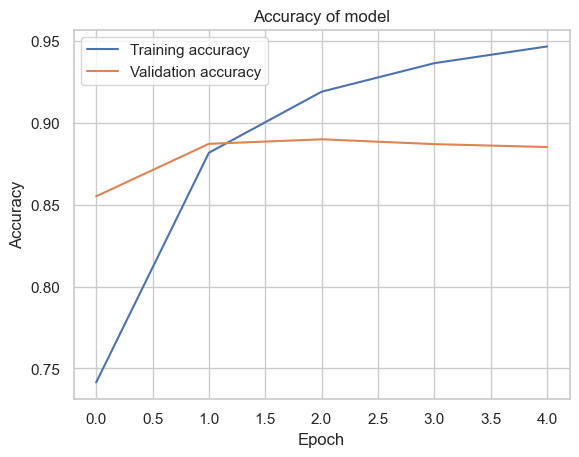

In [59]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

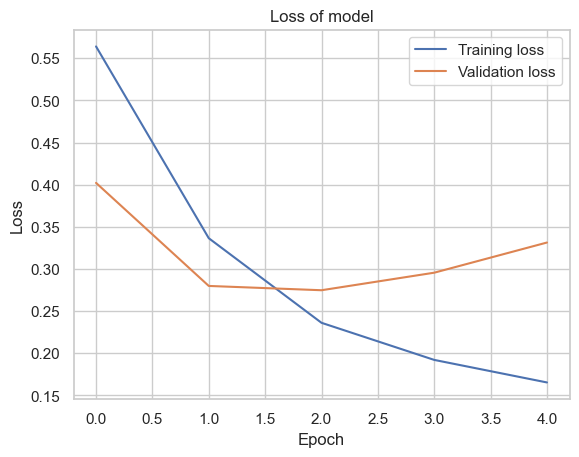

In [60]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
results = dropout_model.evaluate(test_data, verbose=2)

for name, value in zip(dropout_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 2s - loss: 0.3206 - acc: 0.8881 - 2s/epoch - 111ms/step
loss: 0.321
acc: 0.888


**L2 weight regularization**

In [62]:
l2_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                 loss='binary_crossentropy',
                 metrics=['acc'])

history = train_model(l2_model, train_data, valid_data)

Epoch 1/10


2023-04-19 19:13:28.846746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 49s - loss: 0.5131 - acc: 0.7671 - val_loss: 0.3778 - val_acc: 0.8428 - 49s/epoch - 737ms/step
Epoch 2/10
66/66 - 48s - loss: 0.2367 - acc: 0.9346 - val_loss: 0.3232 - val_acc: 0.8866 - 48s/epoch - 725ms/step
Epoch 3/10
66/66 - 48s - loss: 0.1584 - acc: 0.9623 - val_loss: 0.3570 - val_acc: 0.8829 - 48s/epoch - 730ms/step
Epoch 4/10
66/66 - 48s - loss: 0.1349 - acc: 0.9700 - val_loss: 0.3847 - val_acc: 0.8793 - 48s/epoch - 729ms/step
Validation accuracy: 0.879308819770813, loss: 0.3847429156303406


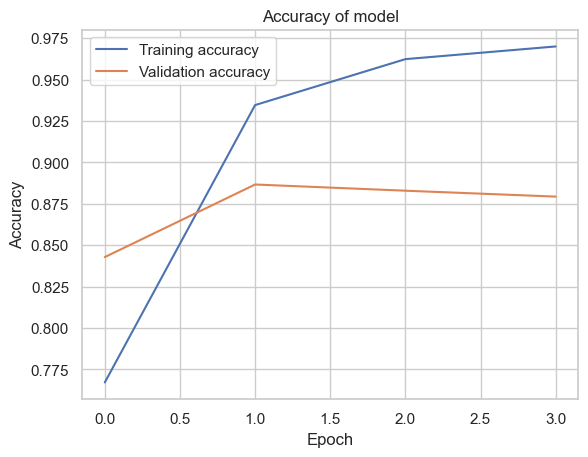

In [63]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

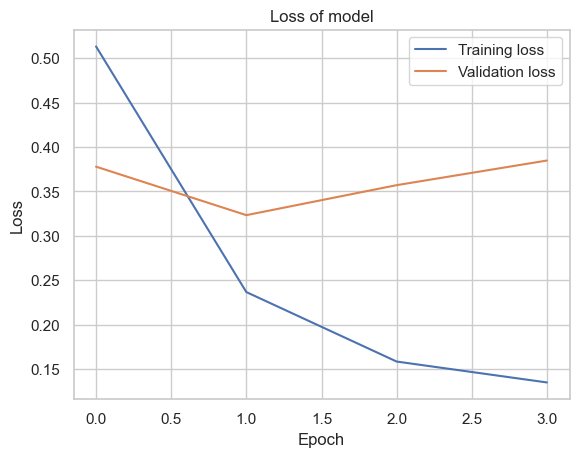

In [64]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
results = l2_model.evaluate(test_data, verbose=2)

for name, value in zip(l2_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 2s - loss: 0.3727 - acc: 0.8853 - 2s/epoch - 112ms/step
loss: 0.373
acc: 0.885


**L2 + dropout**

In [66]:
l2_dropout_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

l2_dropout_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                         loss='binary_crossentropy',
                         metrics=['acc'])

history = train_model(l2_dropout_model, train_data, valid_data)

Epoch 1/10


2023-04-19 19:16:44.685071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 49s - loss: 0.6946 - acc: 0.6284 - val_loss: 0.5546 - val_acc: 0.7959 - 49s/epoch - 744ms/step
Epoch 2/10
66/66 - 48s - loss: 0.4392 - acc: 0.8222 - val_loss: 0.3342 - val_acc: 0.8794 - 48s/epoch - 731ms/step
Epoch 3/10
66/66 - 48s - loss: 0.3109 - acc: 0.8728 - val_loss: 0.3183 - val_acc: 0.8846 - 48s/epoch - 731ms/step
Epoch 4/10
66/66 - 48s - loss: 0.2522 - acc: 0.9107 - val_loss: 0.3306 - val_acc: 0.8847 - 48s/epoch - 731ms/step
Epoch 5/10
66/66 - 48s - loss: 0.2126 - acc: 0.9379 - val_loss: 0.3588 - val_acc: 0.8815 - 48s/epoch - 734ms/step
Validation accuracy: 0.8815355896949768, loss: 0.35880517959594727


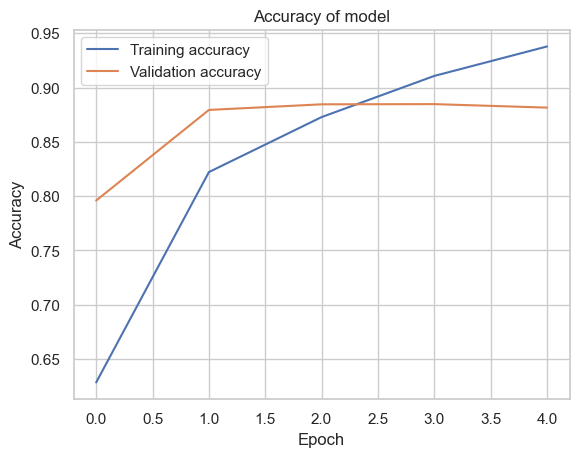

In [67]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

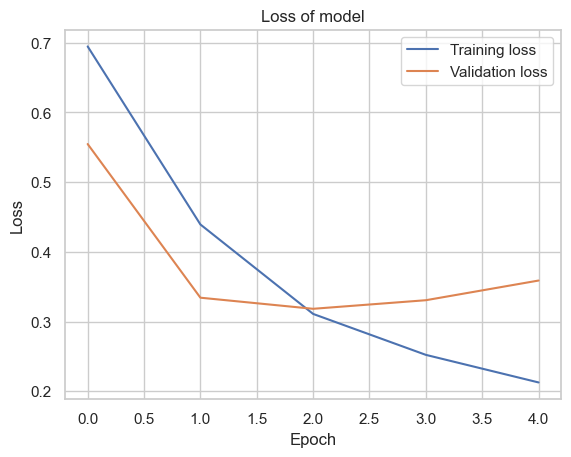

In [68]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
results = dropout_model.evaluate(test_data, verbose=2)

for name, value in zip(dropout_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 3s - loss: 0.3686 - acc: 0.8833 - 3s/epoch - 115ms/step
loss: 0.369
acc: 0.883


### Recurrent Neural Networks & Separable Convolutional Neural Networks

In [70]:
TOP_K = 20000
MAX_SEQUENCE_LENGTH = 500
N_TRAIN = int(0.6 * len(df))
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [71]:
train, valid, test = np.split(df.sample(frac=1), [N_TRAIN, int(0.8 * len(df))])
X_train, y_train = list(train['text']), np.array(list(train['positivity']))
X_valid, y_valid = list(valid['text']), np.array(list(valid['positivity']))
X_test, y_test = list(test['text']), np.array(list(test['positivity']))

In [72]:
def sequence_vectorize(train_texts, val_texts, test_texts):
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    x_test = tokenizer.texts_to_sequences(test_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    x_test = sequence.pad_sequences(x_test, maxlen=max_length)
    return x_train, x_val, x_test, tokenizer.word_index

In [73]:
x_train, x_val, x_test, word_index = sequence_vectorize(X_train, X_valid, X_test)

print(x_train.shape, x_val.shape, x_test.shape, len(word_index))

(33682, 500) (11227, 500) (11228, 500) 25136


In [74]:
num_features = min(len(word_index) + 1, TOP_K)
embedding_dim = 200
input_shape = x_train.shape[1:]
dropout_rate = 0.2
filters = 64
kernel_size = 3
pool_size = 3
learning_rate = 1e-3
epochs=25

**Recurrent Neural Networks**

In [77]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_features,
                           output_dim=embedding_dim,
                           input_length=input_shape[0]))
model.add(layers.SpatialDropout1D(dropout_rate))
model.add(layers.LSTM(units=100,
                      dropout=dropout_rate,
                      recurrent_dropout=dropout_rate,
                      return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

In [79]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, y_valid),
    verbose=2,
    batch_size=BATCH_SIZE)

# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
      acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Epoch 1/25
66/66 - 242s - loss: 0.4421 - acc: 0.7975 - val_loss: 0.2924 - val_acc: 0.8828 - 242s/epoch - 4s/step
Epoch 2/25
66/66 - 250s - loss: 0.2392 - acc: 0.9054 - val_loss: 0.2491 - val_acc: 0.8955 - 250s/epoch - 4s/step
Epoch 3/25
66/66 - 256s - loss: 0.1872 - acc: 0.9282 - val_loss: 0.2569 - val_acc: 0.9008 - 256s/epoch - 4s/step
Epoch 4/25
66/66 - 259s - loss: 0.1572 - acc: 0.9402 - val_loss: 0.2581 - val_acc: 0.8934 - 259s/epoch - 4s/step
Validation accuracy: 0.8933820128440857, loss: 0.2580987513065338


In [80]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

351/351 - 26s - loss: 0.2551 - acc: 0.8970 - 26s/epoch - 74ms/step
loss: 0.255
acc: 0.897


**Separable Convolutional Neural Networks**

In [81]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_features,
                           output_dim=embedding_dim,
                           input_length=input_shape[0]))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.SeparableConv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.SeparableConv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.MaxPooling1D(pool_size=pool_size))
model.add(layers.SeparableConv1D(filters=filters * 2,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.SeparableConv1D(filters=filters * 2,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Dense(1, activation='sigmoid'))

In [82]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

In [83]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, y_valid),
    verbose=2,
    batch_size=BATCH_SIZE)

# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
      acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Epoch 1/25
66/66 - 76s - loss: 0.6186 - acc: 0.7474 - val_loss: 0.5464 - val_acc: 0.7660 - 76s/epoch - 1s/step
Epoch 2/25
66/66 - 75s - loss: 0.5421 - acc: 0.7685 - val_loss: 0.5424 - val_acc: 0.7660 - 75s/epoch - 1s/step
Epoch 3/25
66/66 - 75s - loss: 0.5396 - acc: 0.7685 - val_loss: 0.5389 - val_acc: 0.7660 - 75s/epoch - 1s/step
Epoch 4/25
66/66 - 76s - loss: 0.5326 - acc: 0.7683 - val_loss: 0.5226 - val_acc: 0.7621 - 76s/epoch - 1s/step
Epoch 5/25
66/66 - 75s - loss: 0.5145 - acc: 0.7658 - val_loss: 0.4908 - val_acc: 0.7754 - 75s/epoch - 1s/step
Epoch 6/25
66/66 - 75s - loss: 0.4257 - acc: 0.8194 - val_loss: 0.3743 - val_acc: 0.8533 - 75s/epoch - 1s/step
Epoch 7/25
66/66 - 74s - loss: 0.3345 - acc: 0.8735 - val_loss: 0.3336 - val_acc: 0.8714 - 74s/epoch - 1s/step
Epoch 8/25
66/66 - 74s - loss: 0.2869 - acc: 0.8937 - val_loss: 0.3158 - val_acc: 0.8840 - 74s/epoch - 1s/step
Epoch 9/25
66/66 - 74s - loss: 0.2595 - acc: 0.9051 - val_loss: 0.3230 - val_acc: 0.8800 - 74s/epoch - 1s/step
E

In [84]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

351/351 - 4s - loss: 0.3223 - acc: 0.8918 - 4s/epoch - 10ms/step
loss: 0.322
acc: 0.892
